In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [11]:
from tqdm import tqdm

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [12]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [13]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [14]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [15]:
train_data=train_data[(train_data["TurbID"]==21)]

In [16]:
train_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
576000,21,1,00:00,3.07,-2.56,8.18,23.20,223.45,0.01,0.01,0.01,-77.64,157.50
576001,21,1,00:10,5.46,-10.18,31.62,42.59,170.92,0.35,0.35,0.35,-0.08,293.28
576002,21,1,00:20,5.11,-10.16,31.58,42.74,170.92,0.06,0.06,0.05,-0.04,268.40
576003,21,1,00:30,4.80,-2.57,31.47,42.77,160.98,0.09,0.09,0.09,-0.07,252.73
576004,21,1,00:40,4.74,1.37,31.31,42.54,158.40,0.03,0.03,0.03,-0.07,253.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
604795,21,200,23:10,4.05,-2.56,11.24,22.20,345.07,0.01,0.01,0.01,-73.00,200.87
604796,21,200,23:20,4.66,2.31,11.93,22.21,345.07,0.01,0.01,0.01,-123.33,278.29
604797,21,200,23:30,4.26,-4.19,11.43,22.30,345.07,0.01,0.01,0.01,-116.03,219.26
604798,21,200,23:40,3.32,-4.87,11.40,22.22,337.15,0.01,0.01,0.01,-70.42,140.48


# 데이터셋

In [17]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["TurbID","Patv"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y



In [20]:
tms_list = list(pd.unique(train_data["Tmstamp"]))
train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )


In [23]:
tms_list

['00:00',
 '00:10',
 '00:20',
 '00:30',
 '00:40',
 '00:50',
 '01:00',
 '01:10',
 '01:20',
 '01:30',
 '01:40',
 '01:50',
 '02:00',
 '02:10',
 '02:20',
 '02:30',
 '02:40',
 '02:50',
 '03:00',
 '03:10',
 '03:20',
 '03:30',
 '03:40',
 '03:50',
 '04:00',
 '04:10',
 '04:20',
 '04:30',
 '04:40',
 '04:50',
 '05:00',
 '05:10',
 '05:20',
 '05:30',
 '05:40',
 '05:50',
 '06:00',
 '06:10',
 '06:20',
 '06:30',
 '06:40',
 '06:50',
 '07:00',
 '07:10',
 '07:20',
 '07:30',
 '07:40',
 '07:50',
 '08:00',
 '08:10',
 '08:20',
 '08:30',
 '08:40',
 '08:50',
 '09:00',
 '09:10',
 '09:20',
 '09:30',
 '09:40',
 '09:50',
 '10:00',
 '10:10',
 '10:20',
 '10:30',
 '10:40',
 '10:50',
 '11:00',
 '11:10',
 '11:20',
 '11:30',
 '11:40',
 '11:50',
 '12:00',
 '12:10',
 '12:20',
 '12:30',
 '12:40',
 '12:50',
 '13:00',
 '13:10',
 '13:20',
 '13:30',
 '13:40',
 '13:50',
 '14:00',
 '14:10',
 '14:20',
 '14:30',
 '14:40',
 '14:50',
 '15:00',
 '15:10',
 '15:20',
 '15:30',
 '15:40',
 '15:50',
 '16:00',
 '16:10',
 '16:20',
 '16:30',


[0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 14,
 14,
 14,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 16,
 16,
 17,
 17,
 17,
 17,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 19,
 19,
 19,
 19,
 20,
 20,
 20,
 20,
 20,
 20,
 21,
 21,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 23,
 23,
 23,
 23,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,


In [28]:
train_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
576000,21,1,0,3.07,-2.56,8.18,23.20,223.45,0.01,0.01,0.01,-77.64,157.50
576001,21,1,1,5.46,-10.18,31.62,42.59,170.92,0.35,0.35,0.35,-0.08,293.28
576002,21,1,2,5.11,-10.16,31.58,42.74,170.92,0.06,0.06,0.05,-0.04,268.40
576003,21,1,3,4.80,-2.57,31.47,42.77,160.98,0.09,0.09,0.09,-0.07,252.73
576004,21,1,4,4.74,1.37,31.31,42.54,158.40,0.03,0.03,0.03,-0.07,253.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
604795,21,200,139,4.05,-2.56,11.24,22.20,345.07,0.01,0.01,0.01,-73.00,200.87
604796,21,200,140,4.66,2.31,11.93,22.21,345.07,0.01,0.01,0.01,-123.33,278.29
604797,21,200,141,4.26,-4.19,11.43,22.30,345.07,0.01,0.01,0.01,-116.03,219.26
604798,21,200,142,3.32,-4.87,11.40,22.22,337.15,0.01,0.01,0.01,-70.42,140.48


In [9]:
tms_list = list(pd.unique(train_data["Tmstamp"]))
train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )
train_data["Tmstamp"] = train_data["Tmstamp"]//6



X_data, Y_data = make_train_data(train_data)
X_data  = np.array(X_data).reshape(-1, X_data[0].shape[0], X_data[0].shape[1])
#train_x = np.array(X_data)
Y_data = np.array(Y_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


In [9]:
from datetime import datetime
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
#출처: https://today-1.tistory.com/55 [Better Than,:티스토리]

In [10]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))
hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


# Fourier Features
train_data['sin_24_1'] = np.sin(2 * np.pi * train_data['Tmstamp']/23.0)
train_data['cos_24_1'] = np.cos(2 * np.pi * train_data['Tmstamp']/23.0)
fourier_features(train_data['Tmstamp'], 24, 1)

train_data.drop(['Tmstamp'],axis=1,inplace=True)

X_data, Y_data = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.95it/s]


In [11]:
np.array(X_data)

array([[[ 1.0000000e+00,  3.0700000e+00, -2.5600000e+00, ...,
          1.5750000e+02,  0.0000000e+00,  1.0000000e+00],
        [ 1.0000000e+00,  5.4600000e+00, -1.0180000e+01, ...,
          2.9328000e+02,  0.0000000e+00,  1.0000000e+00],
        [ 1.0000000e+00,  5.1100000e+00, -1.0160000e+01, ...,
          2.6840000e+02,  0.0000000e+00,  1.0000000e+00],
        ...,
        [ 5.0000000e+00,  6.5400000e+00, -5.0100000e+00, ...,
          5.8565000e+02, -2.4492936e-16,  1.0000000e+00],
        [ 5.0000000e+00,  5.5000000e+00, -7.6900000e+00, ...,
          3.5390000e+02, -2.4492936e-16,  1.0000000e+00],
        [ 5.0000000e+00,  5.7800000e+00,  3.2900000e+00, ...,
          4.4965000e+02, -2.4492936e-16,  1.0000000e+00]],

       [[ 2.0000000e+00,  9.0500000e+00, -4.4300000e+00, ...,
          1.0364500e+03,  0.0000000e+00,  1.0000000e+00],
        [ 2.0000000e+00,  9.0900000e+00, -4.1200000e+00, ...,
          1.0951100e+03,  0.0000000e+00,  1.0000000e+00],
        [ 2.0000000e+00, 

In [12]:
X_data  = np.array(X_data).reshape(-1, X_data[0].shape[0], X_data[0].shape[1])
#train_x = np.array(X_data)
Y_data = np.array(Y_data)

In [10]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#valid_x = np.array(valid_x)
#valid_y = np.array(valid_y)

from sktime.forecasting.all import temporal_train_test_split

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\sktime\utils\validation\_dependencies.py:113: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


In [11]:
train_y, valid_y, train_x, valid_x = temporal_train_test_split(X=X_data,y=Y_data, test_size=0.1)

In [12]:
train_y.shape

(174, 288)

In [13]:
np.array(train_y).shape

(174, 288)

In [14]:
train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y= np.array(train_y)
print(train_x.shape, train_y.shape)

(174, 720, 11) (174, 288)


In [15]:
valid_x  = np.array(valid_x).reshape(-1, valid_x[0].shape[0], valid_x[0].shape[1])
valid_y = np.array(valid_y)
print(valid_x.shape, valid_y.shape)

(20, 720, 11) (20, 288)


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

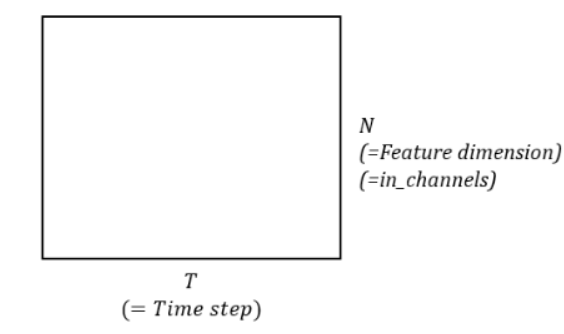

# 데이터 로더

In [16]:
EPOCHS = 50
BATCH_SIZE = 64
lr = 1e-3

In [17]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [18]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [19]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([64, 720, 11]) type: torch.FloatTensor
Y_train :  torch.Size([64, 288]) type: torch.FloatTensor
torch.Size([288])


In [20]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([20, 720, 11]) type: torch.FloatTensor
Y_valid :  torch.Size([20, 288]) type: torch.FloatTensor
torch.Size([288])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [26]:
lstm = nn.LSTM(input_size=12, hidden_size=256, batch_first=True, bidirectional=False)

lstm(X_valid)[0].size()

torch.Size([128, 720, 256])

In [27]:
lstm(X_valid)[0][-1].size()

torch.Size([720, 256])

In [28]:
lstm(X_valid)[1][0]

tensor([[[-1.1673e-01,  1.4841e-04,  5.6774e-02,  ...,  1.0000e+00,
           5.9224e-01,  5.0878e-14],
         [-4.8787e-04,  9.9971e-01,  1.9079e-04,  ...,  1.7265e-02,
           9.9996e-01,  1.9422e-02],
         [ 5.0369e-03, -2.1034e-01,  1.4122e-01,  ...,  1.0000e+00,
           9.1735e-01,  2.2290e-30],
         ...,
         [-2.4418e-04,  9.9999e-01,  2.8196e-01,  ...,  4.4332e-02,
           9.9596e-01,  3.0322e-02],
         [-8.8184e-01, -6.1001e-07,  6.1041e-05,  ...,  1.0000e+00,
           1.0000e+00,  3.8480e-29],
         [ 6.1095e-04,  9.9695e-01,  2.8479e-06,  ...,  1.7060e-02,
           9.5216e-01,  7.4001e-03]]], grad_fn=<StackBackward0>)

In [29]:
lstm(X_valid)[0][:,-2,:].size()

torch.Size([128, 256])

In [21]:
lstm_hidden_size=288

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.GRU(input_size=11, hidden_size=lstm_hidden_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size*2,512),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,288), #288개 예측
            nn.ReLU(),  
        )
        
    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.classifier(output[:,-1,:]) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [22]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(X) # model로 output을 계산
        loss = criterion(output, Y)        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
        loss.backward()
        optimizer.step()
    
    train_loss/=len(train_loader.dataset)
    train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss



In [23]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(X) # model로 output을 계산
            
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
    valid_loss/=len(valid_loader.dataset)
    valid_mae/=len(valid_loader.dataset)
    return valid_loss, valid_mae


In [24]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_baseline_21turb.pt'
print(check_path)
model = BaseModel().to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999



for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    
    
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae,
                         valid_loss, valid_mae ))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss ))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss = valid_loss
        
    
    

./checkpoint/checkpoint_baseline_21turb.pt

[EPOCH:1]	 Train Loss:0.6503	 Train MAE:0.0884  | 	Valid Loss:1.3013 	Valid MAE: 0.1902

-- SAVE Checkpoint --
Valid loss : 9999999999.0000 -> 1.3013 


[EPOCH:2]	 Train Loss:0.4184	 Train MAE:0.0665  | 	Valid Loss:1.2437 	Valid MAE: 0.2097

-- SAVE Checkpoint --
Valid loss : 1.3013 -> 1.2437 


[EPOCH:3]	 Train Loss:0.3211	 Train MAE:0.0600  | 	Valid Loss:0.8047 	Valid MAE: 0.1468

-- SAVE Checkpoint --
Valid loss : 1.2437 -> 0.8047 


[EPOCH:4]	 Train Loss:0.3035	 Train MAE:0.0544  | 	Valid Loss:0.7802 	Valid MAE: 0.1460

-- SAVE Checkpoint --
Valid loss : 0.8047 -> 0.7802 


[EPOCH:5]	 Train Loss:0.2901	 Train MAE:0.0552  | 	Valid Loss:0.8127 	Valid MAE: 0.1612


[EPOCH:6]	 Train Loss:0.2707	 Train MAE:0.0539  | 	Valid Loss:0.7363 	Valid MAE: 0.1464

-- SAVE Checkpoint --
Valid loss : 0.7802 -> 0.7363 


[EPOCH:7]	 Train Loss:0.2583	 Train MAE:0.0512  | 	Valid Loss:0.7300 	Valid MAE: 0.1465

-- SAVE Checkpoint --
Valid loss : 0.7363 -> 0.7

In [34]:
ddddd

NameError: name 'ddddd' is not defined

# validation 확인

In [168]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.6939 / Valid MAE : 0.1447 



In [25]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.7149 / Valid MAE : 0.1461 



# TEST

In [26]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data.drop(["TurbID","Patv"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [27]:
test_data.shape

(1, 720, 11)

In [28]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [29]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [30]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline_21turb.pt')
model.load_state_dict(best_checkpoint)
model.eval()

BaseModel(
  (lstm): GRU(11, 288, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=288, bias=True)
    (7): ReLU()
  )
)

In [31]:
preds = predict(model, test_loader)
preds = preds.reshape(-1)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.95it/s]


In [32]:
sample_submission = sample_submission[sample_submission["TurbID"]==21]

In [33]:
sample_submission["Wspd"] = preds
sample_submission.to_csv("./submit.csv", index = False)

In [34]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
5760,5760,21,201,00:00,0.000000,0,0,0,0,0,0,0,0,9999
5761,5761,21,201,00:10,4.053669,0,0,0,0,0,0,0,0,9999
5762,5762,21,201,00:20,4.221068,0,0,0,0,0,0,0,0,9999
5763,5763,21,201,00:30,3.954623,0,0,0,0,0,0,0,0,9999
5764,5764,21,201,00:40,4.019324,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6043,6043,21,202,23:10,0.000000,0,0,0,0,0,0,0,0,9999
6044,6044,21,202,23:20,3.794113,0,0,0,0,0,0,0,0,9999
6045,6045,21,202,23:30,3.766567,0,0,0,0,0,0,0,0,9999
6046,6046,21,202,23:40,3.803301,0,0,0,0,0,0,0,0,9999


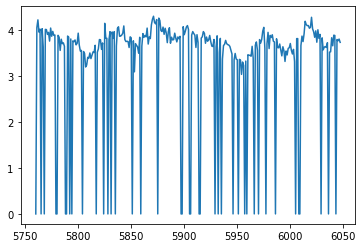

In [35]:
plt.plot(sample_submission['Wspd'])

# 검증 set

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose


#train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
#train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

#for turb in range(1,135):
#    result = seasonal_decompose(train_data[(train_data["TurbID"]==turb)].Wspd,model='additive',period=144)
#    resid = result.resid.fillna(method='ffill').fillna(method='bfill')
#    train_data.loc[(train_data["TurbID"]==turb),'wnd_resid' ]=resid
    
#tms_list = list(pd.unique(train_data["Tmstamp"]))
#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )


TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [38]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(56, 61)]

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data.drop(["TurbID","Patv"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [39]:
test_data.shape

(1, 720, 11)

In [40]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [41]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [42]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline_21turb.pt')
model.load_state_dict(best_checkpoint)
model.eval()

preds = predict(model, test_loader)
preds = preds.reshape(-1)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.06it/s]


In [43]:
preds

array([0.        , 5.12109041, 5.25143909, 4.94477797, 5.02389383,
       0.        , 4.96092892, 4.55223608, 0.        , 4.9696002 ,
       4.97895479, 4.81729698, 4.9161911 , 4.63291264, 5.07077456,
       4.78354073, 4.91293764, 4.84839678, 4.85728264, 0.        ,
       0.        , 4.82755041, 4.71653557, 4.42272329, 4.58500624,
       4.51881933, 4.65002537, 4.59565306, 0.        , 0.        ,
       4.74480152, 4.7644763 , 0.        , 4.62925482, 0.        ,
       4.70633316, 4.67824554, 4.62709379, 4.55417347, 4.60885   ,
       4.83311796, 4.49575567, 4.39040804, 4.35363579, 0.        ,
       4.3739419 , 4.2886796 , 4.0009079 , 3.98137927, 4.09206486,
       4.19591951, 4.30564785, 4.11742258, 4.23770809, 4.36812258,
       4.33354044, 4.49787521, 0.        , 4.3365097 , 4.49429321,
       4.62767315, 4.65141964, 4.47541952, 4.5602417 , 0.        ,
       5.10182428, 4.70310593, 4.70731068, 0.        , 4.75568438,
       4.92640114, 0.        , 4.87541723, 4.72888994, 4.84097

In [44]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission = sample_submission[sample_submission['TurbID']==21]


In [45]:
sample_submission.loc[sample_submission['Day']==201,'Day'] = 61

In [46]:
sample_submission.loc[sample_submission['Day']==202,'Day'] = 62

In [47]:
sample_submission['Wspd']=preds

In [48]:
plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd']

NameError: name 'plot_data' is not defined

Text(0.5, 1.0, 'TurbID : 21, Day:61')

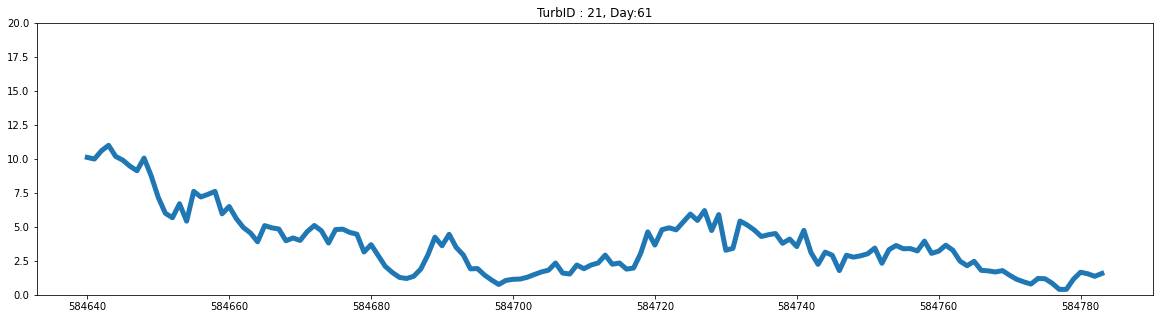

In [50]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 61 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Patv'])
#    plt.xticks([])
plt.ylim([0,20])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')




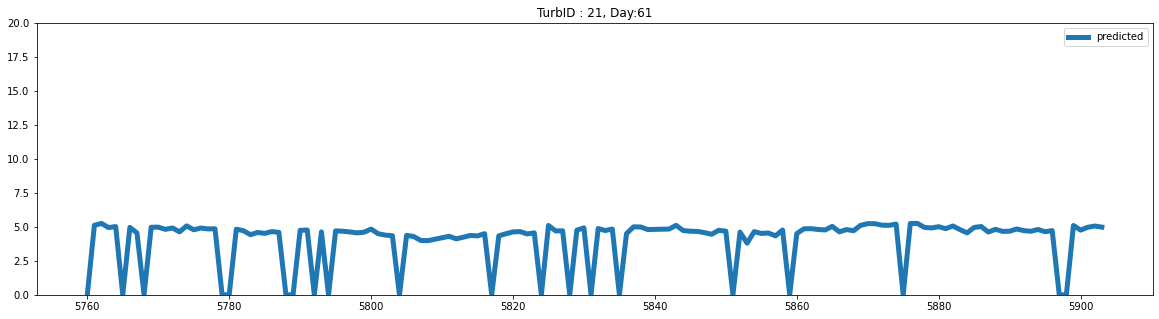

In [51]:
plot_data = sample_submission
plt.figure(figsize=(20, 5))
k = 21 # turb id
plt.plot( plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='predicted')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim([0,20])

plt.legend()

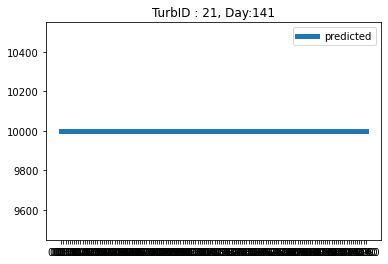

In [46]:
plot_data = sample_submission
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Patv'], linewidth=5.0,
        label='predicted')
plt.title(f'TurbID : {k}, Day:{j}')
plt.legend()

In [47]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,141,00:00,0,0,0,0,0,0,0,0,0,9999
1,1,1,141,00:10,0,0,0,0,0,0,0,0,0,9999
2,2,1,141,00:20,0,0,0,0,0,0,0,0,0,9999
3,3,1,141,00:30,0,0,0,0,0,0,0,0,0,9999
4,4,1,141,00:40,0,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,142,23:10,0,0,0,0,0,0,0,0,0,9999
38588,38588,134,142,23:20,0,0,0,0,0,0,0,0,0,9999
38589,38589,134,142,23:30,0,0,0,0,0,0,0,0,0,9999
38590,38590,134,142,23:40,0,0,0,0,0,0,0,0,0,9999
